In [1]:
import os
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer

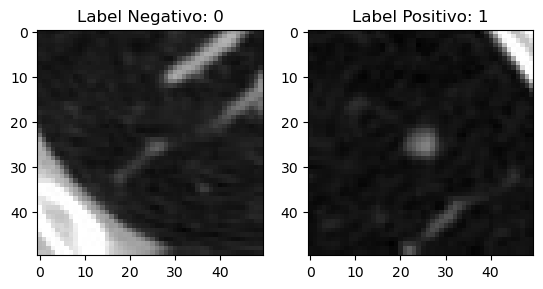

In [2]:
#observamos las imágenes
plt.subplot(1, 2, 1)
plt.title('Label Negativo: 0')
plt.imshow(cv2.imread('data\\images\\image_1054.jpg'))

plt.subplot(1, 2, 2)
plt.title('Label Positivo: 1')
plt.imshow(cv2.imread('data\\images\\image_13.jpg'))

plt.show()

## Pre-procesamiento de los Datos
Unir en un solo dataset las imagenes con sus labels

In [3]:
df = pd.read_csv('data\\labels.txt', sep=" ", header = None)
df.columns =['filepaths', 'labels']
df.head()

,filepaths,labels
0,data/images/image_189342.jpg,0
1,data/images/image_145102.jpg,0
2,data/images/image_31546.jpg,0
3,data/images/image_441280.jpg,1
4,data/images/image_215578.jpg,0


In [4]:
df = shuffle(df).reset_index(drop = True)
print (df['labels'].value_counts())

0    6755
1    1351
Name: labels, dtype: int64


In [5]:
# Se separan los datos en training, validacion y test
X_train, X_test, y_train, y_test = train_test_split(df['filepaths'], df['labels'], test_size=0.30, random_state=33)
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, train_size=0.5, random_state=34)

print('Cantidad de datos en cada set\n')
print('Training:', len(y_train), '\t\t0:', y_train.value_counts()[0],', 1:' ,y_train.value_counts()[1])
print('Validacion:', len(y_val), '\t0:', y_val.value_counts()[0],', 1:' ,y_val.value_counts()[1])
print('Test:', len(y_test), '\t\t0:', y_test.value_counts()[0],', 1:' ,y_test.value_counts()[1])

Cantidad de datos en cada set

Training: 5674 		0: 4740 , 1: 934
Validacion: 1216 	0: 1019 , 1: 197
Test: 1216 		0: 996 , 1: 220


## Pre-procesamiento de las imagenes

In [6]:
IMG_SIZE = 50

def preprocessig_data(data):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Pasamos la imagen a escala de grises
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0 # normalizamos los pixeles de la imagen
        X.append(img)
    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) #Hacemos un reshape de las imagenes
    return X

X_train = preprocessig_data(X_train)
X_val = preprocessig_data(X_val)

In [7]:
# Usamos labelEncoder para manejar los labels como numeros
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

## Red convolucional de al menos 3 capas convolucionales

In [8]:
model_base = tf.keras.models.Sequential([

  Conv2D(32, kernel_size= (3,3), activation='relu', input_shape =(IMG_SIZE,IMG_SIZE,1)),
  MaxPooling2D(),

  Conv2D(64, kernel_size = (3,3), activation='relu'),
  MaxPooling2D(),
    
  Conv2D(128, kernel_size = (3,3), activation='relu'),

  Conv2D(256, kernel_size = (3,3), activation='relu'),
  MaxPooling2D(),
    
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.2),
    
  Dense(64, activation='relu'),
  Dropout(0.2),

  Dense(32, activation='relu'),
  Dropout(0.2),

  Dense(16, activation='relu'),
  Dropout(0.2),    
    
  Dense(1, activation= 'sigmoid') # Se tienen 2 posibles clases
])

callbacks = [
    ModelCheckpoint(
    filepath="modelos/checkpoint_model4a",
    save_best_only=True,
    monitor="val_loss")
]

model_base.compile(optimizer='RMSprop',loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['Precision', 'Recall'])
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         2

In [9]:
history_base = model_base.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=40, epochs = 200, callbacks=callbacks)

Epoch 1/200
142/142 [==============================] - ETA: 0s - loss: 0.4451 - precision: 0.1923 - recall: 0.0054

INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


142/142 [==============================] - 34s 225ms/step - loss: 0.4451 - precision: 0.1923 - recall: 0.0054 - val_loss: 0.3367 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
142/142 [==============================] - ETA: 0s - loss: 0.3502 - precision: 0.5870 - recall: 0.0867

INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


142/142 [==============================] - 30s 210ms/step - loss: 0.3502 - precision: 0.5870 - recall: 0.0867 - val_loss: 0.2999 - val_precision: 0.5795 - val_recall: 0.5736
Epoch 3/200
142/142 [==============================] - ETA: 0s - loss: 0.2857 - precision: 0.6549 - recall: 0.5161

INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


142/142 [==============================] - 27s 190ms/step - loss: 0.2857 - precision: 0.6549 - recall: 0.5161 - val_loss: 0.2328 - val_precision: 0.6667 - val_recall: 0.6701
Epoch 4/200
142/142 [==============================] - ETA: 0s - loss: 0.2659 - precision: 0.6997 - recall: 0.5814

INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


142/142 [==============================] - 26s 184ms/step - loss: 0.2659 - precision: 0.6997 - recall: 0.5814 - val_loss: 0.2123 - val_precision: 0.8056 - val_recall: 0.5888
Epoch 5/200
142/142 [==============================] - 22s 153ms/step - loss: 0.2277 - precision: 0.7470 - recall: 0.6606 - val_loss: 0.2152 - val_precision: 0.8795 - val_recall: 0.3706
Epoch 6/200
142/142 [==============================] - 24s 171ms/step - loss: 0.2054 - precision: 0.7650 - recall: 0.7109 - val_loss: 0.2143 - val_precision: 0.7281 - val_recall: 0.8020
Epoch 7/200
142/142 [==============================] - ETA: 0s - loss: 0.1819 - precision: 0.7984 - recall: 0.7634

INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


142/142 [==============================] - 30s 210ms/step - loss: 0.1819 - precision: 0.7984 - recall: 0.7634 - val_loss: 0.2027 - val_precision: 0.8279 - val_recall: 0.5127
Epoch 8/200
142/142 [==============================] - ETA: 0s - loss: 0.1577 - precision: 0.8275 - recall: 0.7912

INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


142/142 [==============================] - 26s 181ms/step - loss: 0.1577 - precision: 0.8275 - recall: 0.7912 - val_loss: 0.1885 - val_precision: 0.8333 - val_recall: 0.6091
Epoch 9/200
142/142 [==============================] - ETA: 0s - loss: 0.1400 - precision: 0.8482 - recall: 0.8137

INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


INFO:tensorflow:Assets written to: modelos\checkpoint_model4a\assets


142/142 [==============================] - 31s 219ms/step - loss: 0.1400 - precision: 0.8482 - recall: 0.8137 - val_loss: 0.1717 - val_precision: 0.7882 - val_recall: 0.8122
Epoch 10/200
142/142 [==============================] - 27s 188ms/step - loss: 0.1327 - precision: 0.8609 - recall: 0.8019 - val_loss: 0.1794 - val_precision: 0.8041 - val_recall: 0.7919
Epoch 11/200
142/142 [==============================] - 23s 160ms/step - loss: 0.1149 - precision: 0.8964 - recall: 0.8522 - val_loss: 0.2074 - val_precision: 0.7913 - val_recall: 0.8274
Epoch 12/200
142/142 [==============================] - 24s 171ms/step - loss: 0.1089 - precision: 0.9010 - recall: 0.8672 - val_loss: 0.2013 - val_precision: 0.8225 - val_recall: 0.7056
Epoch 13/200
142/142 [==============================] - 27s 190ms/step - loss: 0.0918 - precision: 0.9276 - recall: 0.8919 - val_loss: 0.2125 - val_precision: 0.8600 - val_recall: 0.6548
Epoch 14/200
142/142 [==============================] - 30s 209ms/step - loss:

In [10]:
X_test= preprocessig_data(X_test)
y_test = le.transform(y_test)

In [11]:
# Evaluacion del modelo con el conjunto de Test
score = model_base.evaluate(X_test, y_test)
print(f'Test loss: {score[0]}\nTest Precision: {score[1]}\nTest Recall: {score[2]}')

38/38 [==============================] - 2s 55ms/step - loss: 13.4761 - precision: 0.7696 - recall: 0.7136
Test loss: 13.476080894470215
Test Precision: 0.7696078419685364
Test Recall: 0.7136363387107849


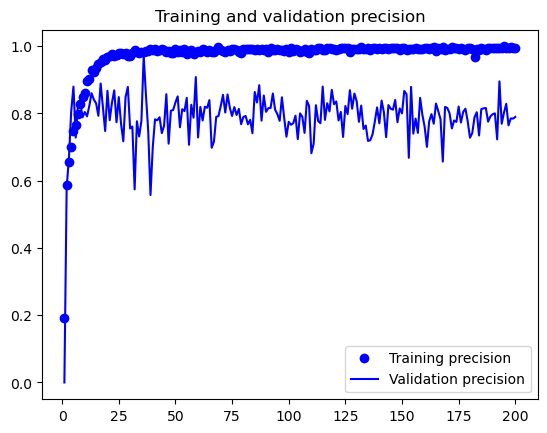

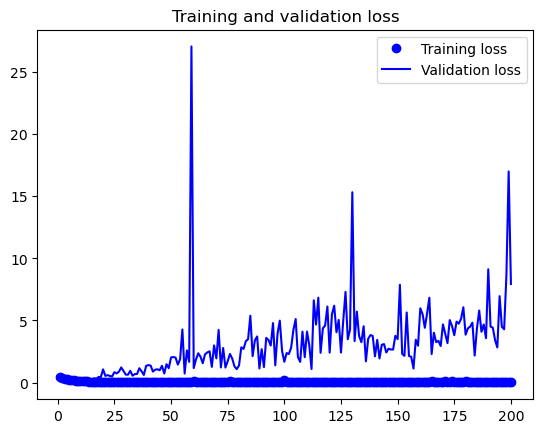

In [12]:
import matplotlib.pyplot as plt
precision = history_base.history["precision"]
val_precision = history_base.history["val_precision"]
loss = history_base.history["loss"]
val_loss = history_base.history["val_loss"]
epochs = range(1, len(precision) + 1)
plt.plot(epochs, precision, "bo", label="Training precision")
plt.plot(epochs, val_precision, "b", label="Validation precision")
plt.title("Training and validation precision")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [13]:
def getRealPrediction(y_aux):
    y_predicted = np.zeros(len(y_aux))
    for i in range(len(y_aux)):
        if y_aux[i] >= 0.5:
            y_predicted[i] = 1
        else:
            y_predicted[i] = 0
    return y_predicted

178/178 [==============================] - 6s 34ms/step
Matriz de Confusión Train


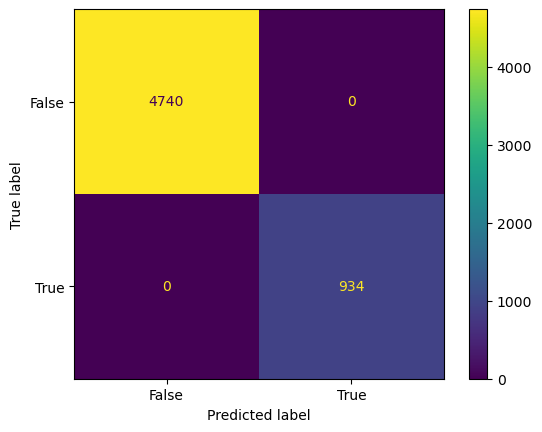

38/38 [==============================] - 1s 32ms/step
Matriz de Confusión Test


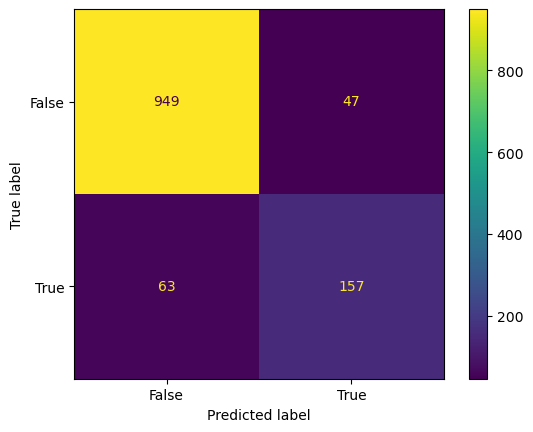

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_aux = model_base.predict(X_train)
y_predicted = getRealPrediction(y_aux)
confusion_matrix = metrics.confusion_matrix(y_train, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
print('Matriz de Confusión Train')
cm_display.plot()
plt.show()

y_aux = model_base.predict(X_test)
y_predicted = getRealPrediction(y_aux)
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
print('Matriz de Confusión Test')
cm_display.plot()
plt.show()

## Deploy del modelo: red convolucional

In [15]:
from tensorflow.keras.models import load_model
test_model = load_model("modelos/checkpoint_model4a")
IMG_SIZE = 50

def preprocessig_data(data):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Pasamos la imagen a escala de grises
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0 # normalizamos los pixeles de la imagen
        X.append(img)
    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) #Hacemos un reshape de las imagenes
    return X

In [16]:
imagenPath = "data\\images\\image_13.jpg" # positiva
inputImage = preprocessig_data([imagenPath])
y_predicted = test_model(inputImage)
percentage = tf.gather(y_predicted, 0)[0].numpy()
real_val = getRealPrediction([percentage])[0]
print('percentage:',f'{round(percentage*100, 5)}%')
print('predicted:',real_val)

percentage: 73.79194%
predicted: 1.0


In [17]:
imagenPath = "data\\images\\image_1054.jpg" # negativa
inputImage = preprocessig_data([imagenPath])
y_predicted = test_model(inputImage)
percentage = tf.gather(y_predicted, 0)[0].numpy()
real_val = getRealPrediction([percentage])[0]
print('percentage:',f'{round(percentage*100, 5)}%')
print('predicted:',real_val)

percentage: 0.0%
predicted: 0.0
